# Initial state identification on full pharyngeal endoderm development data

## Import packages

In [1]:
import sys

import matplotlib.pyplot as plt

import cellrank as cr
import scanpy as sc
import scvelo as scv
import wot

from cr2 import running_in_notebook

sys.path.extend(["../../../", "."])
from paths import DATA_DIR, FIG_DIR  # isort: skip  # noqa: E402

Global seed set to 0


## General settings

In [2]:
sc.settings.verbosity = 2
cr.settings.verbosity = 4
scv.settings.verbosity = 3

In [3]:
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map="viridis")

In [4]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / "realtime_kernel" / "pharyngeal_endoderm").mkdir(parents=True, exist_ok=True)

FIGURE_FORMAT = "pdf"

In [5]:
(DATA_DIR / "pharyngeal_endoderm" / "results").mkdir(parents=True, exist_ok=True)

## Constants

In [6]:
# fmt: off
S_GENES = [
    "Mcm5", "Pcna", "Tyms", "Fen1", "Mcm2", "Mcm4", "Rrm1", "Ung", "Gins2",
    "Mcm6", "Cdca7", "Dtl", "Prim1", "Uhrf1", "Mlf1ip", "Hells", "Rfc2",
    "Rpa2", "Nasp", "Rad51ap1", "Gmnn", "Wdr76", "Slbp", "Ccne2", "Ubr7",
    "Pold3", "Msh2", "Atad2", "Rad51", "Rrm2", "Cdc45", "Cdc6", "Exo1",
    "Tipin", "Dscc1", "Blm", "Casp8ap2", "Usp1", "Clspn", "Pola1", "Chaf1b",
    "Brip1", "E2f8",
]

G2M_GENES = [
    "Hmgb2", "Cdk1", "Nusap1", "Ube2c", "Birc5", "Tpx2", "Top2a", "Ndc80",
    "Cks2", "Nuf2", "Cks1b", "Mki67", "Tmpo", "Cenpf", "Tacc3", "Fam64a",
    "Smc4", "Ccnb2", "Ckap2l", "Ckap2", "Aurkb", "Bub1", "Kif11", "Anp32e",
    "Tubb4b", "Gtse1", "Kif20b", "Hjurp", "Cdca3", "Hn1", "Cdc20", "Ttk",
    "Cdc25c", "Kif2c", "Rangap1", "Ncapd2", "Dlgap5", "Cdca2", "Cdca8",
    "Ect2", "Kif23", "Hmmr", "Aurka", "Psrc1", "Anln", "Lbr", "Ckap5",
    "Cenpe", "Ctcf", "Nek2", "G2e3", "Gas2l3", "Cbx5", "Cenpa",
]
# fmt: on

## Data loading

In [7]:
adata = sc.read(DATA_DIR / "pharyngeal_endoderm" / "raw" / "adata_pharynx.h5ad")
adata.obsm["X_umap"] = adata.obs[["UMAP1", "UMAP2"]].values
adata.obs["day"] = adata.obs["day_str"].astype(float)
adata.obs = adata.obs[["cluster_name", "day", "is_doublet"]]

adata.obs["cluster_name"] = (
    adata.obs["cluster_name"]
    .astype(str)
    .astype("category")
    .cat.rename_categories({"nan": "progenitors"})
    .cat.reorder_categories(["progenitors"] + adata.obs["cluster_name"].cat.categories.tolist())
)
adata.uns["cluster_name_colors"] = [
    "#dedede",
    "#023fa5",
    "#7d87b9",
    "#bec1d4",
    "#d6bcc0",
    "#bb7784",
    "#8e063b",
    "#4a6fe3",
    "#8595e1",
    "#b5bbe3",
    "#e6afb9",
    "#e07b91",
    "#d33f6a",
    "#11c638",
]

adata

AnnData object with n_obs × n_vars = 54044 × 27998
    obs: 'cluster_name', 'day', 'is_doublet'
    uns: 'cluster_name_colors'
    obsm: 'X_umap'

## Data preprocessing

In [8]:
sc.pp.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:15)


In [9]:
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=30)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:02:38)


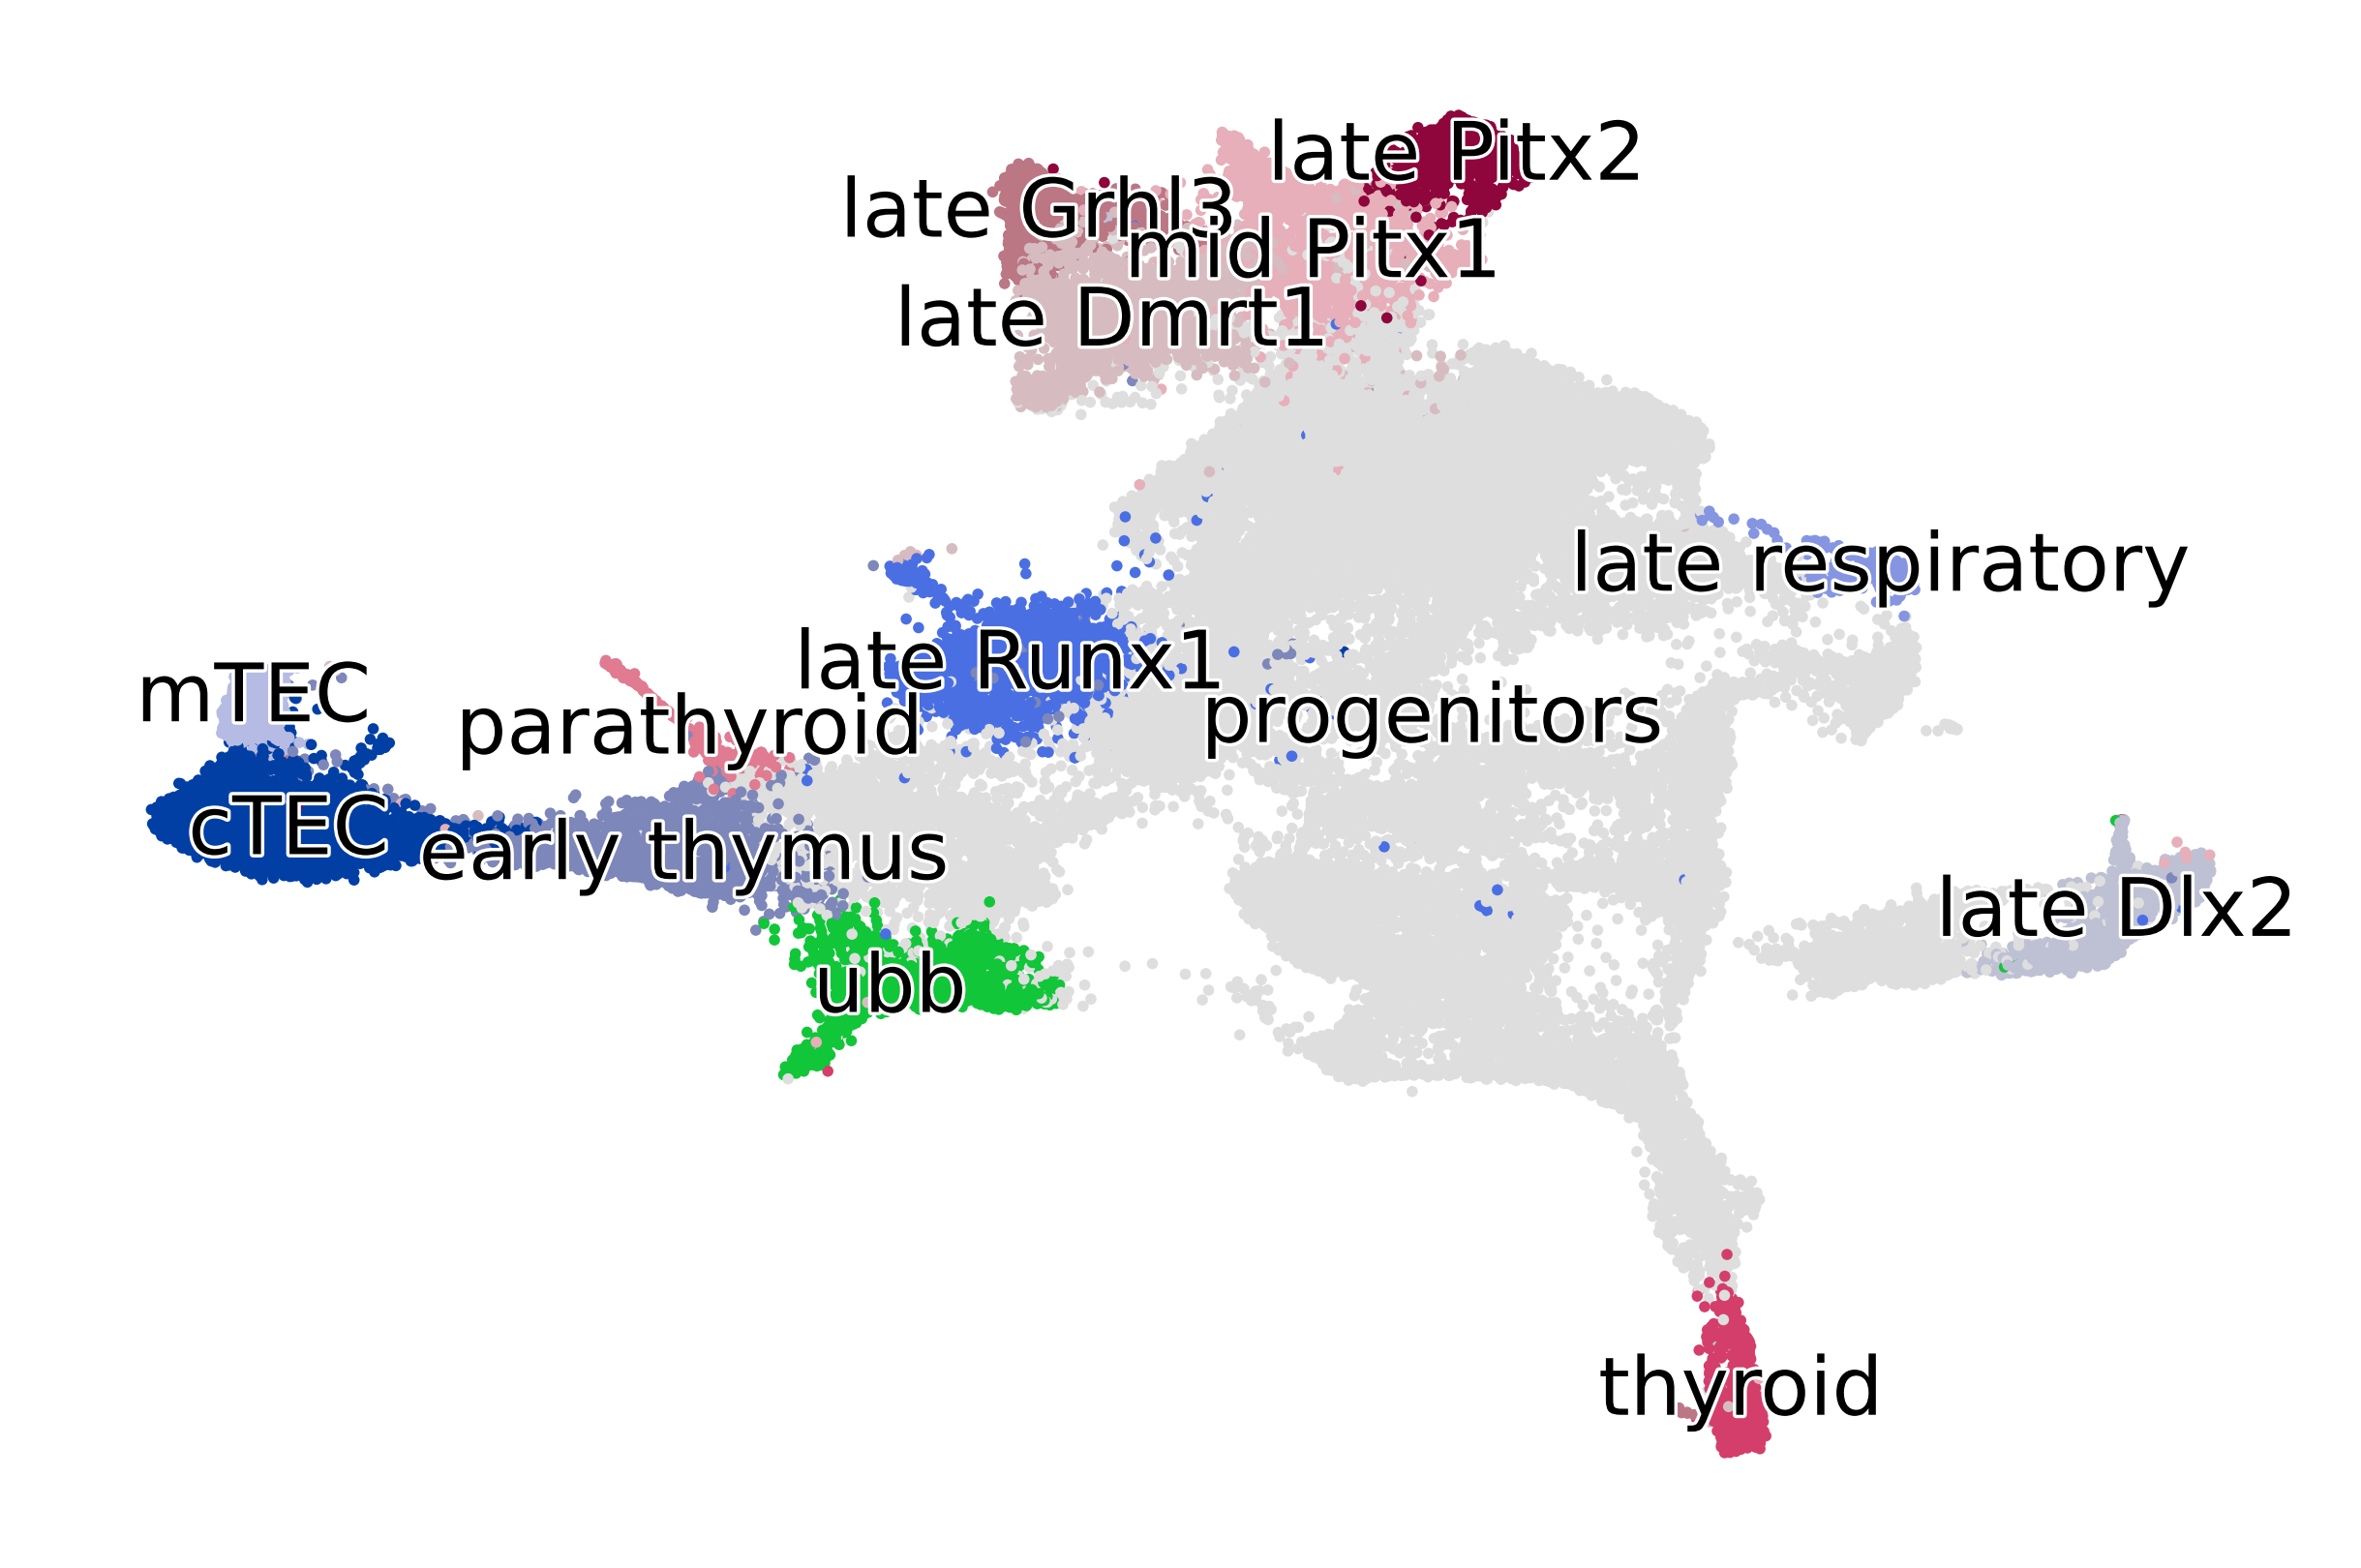

In [10]:
if running_in_notebook():
    scv.pl.scatter(
        adata, basis="umap", c="cluster_name", title="", dpi=250, legend_fontsize=12, legend_fontweight="normal"
    )

## CellRank

### Kernel

In [11]:
if not (DATA_DIR / "pharyngeal_endoderm" / "tmaps_full_data").exists():
    ot_model = wot.ot.OTModel(adata)
    ot_model.compute_all_transport_maps(tmap_out=DATA_DIR / "pharyngeal_endoderm" / "tmaps_full_data" / "tmaps")

In [12]:
adata.obs["day"] = adata.obs["day"].astype("category")

rtk = cr.kernels.RealTimeKernel.from_wot(
    adata, path=DATA_DIR / "pharyngeal_endoderm" / "tmaps_full_data", time_key="day"
)
rtk.compute_transition_matrix(
    growth_iters=3, growth_rate_key="growth_rate_init", self_transitions="all", conn_weight=0.1
)
rtk.transition_matrix = rtk.transition_matrix.T

Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].
Only considering the two last: ['.5', '.h5ad'].


  0%|          | 0/3 [00:00<?, ?time pair/s]

Using automatic `threshold=0.0022490203846246004`
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:01)


### Estimator

Computing Schur decomposition
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)


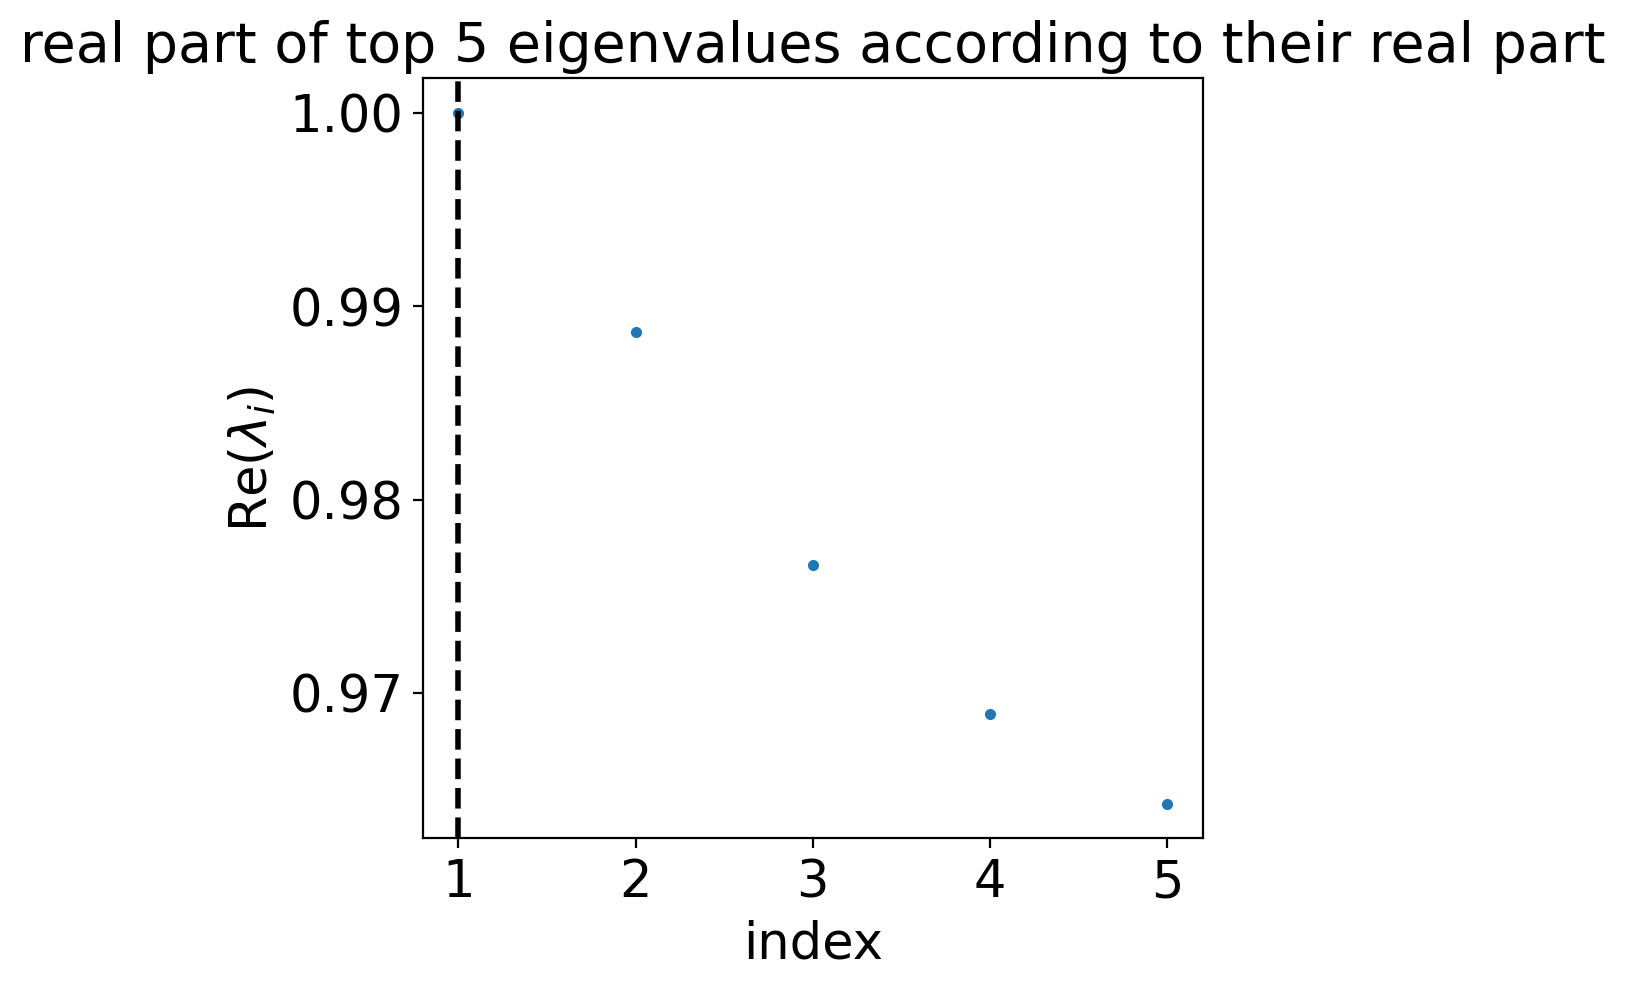

In [13]:
estimator = cr.estimators.GPCCA(rtk)
estimator.compute_schur(n_components=5)
estimator.plot_spectrum(real_only=True)
plt.show()

For 1 macrostate, stationary distribution is computed
Computing eigendecomposition of the transition matrix
DEBUG: Computing top `20` eigenvalues of a sparse matrix
DEBUG: Sorting eigenvalues by their real part
Adding `adata.uns['eigendecomposition_fwd']`
       `.eigendecomposition`
    Finish (0:00:06)
DEBUG: Setting the macrostates using macrostates memberships
DEBUG: Raising an exception if there are less than `6` cells.
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)


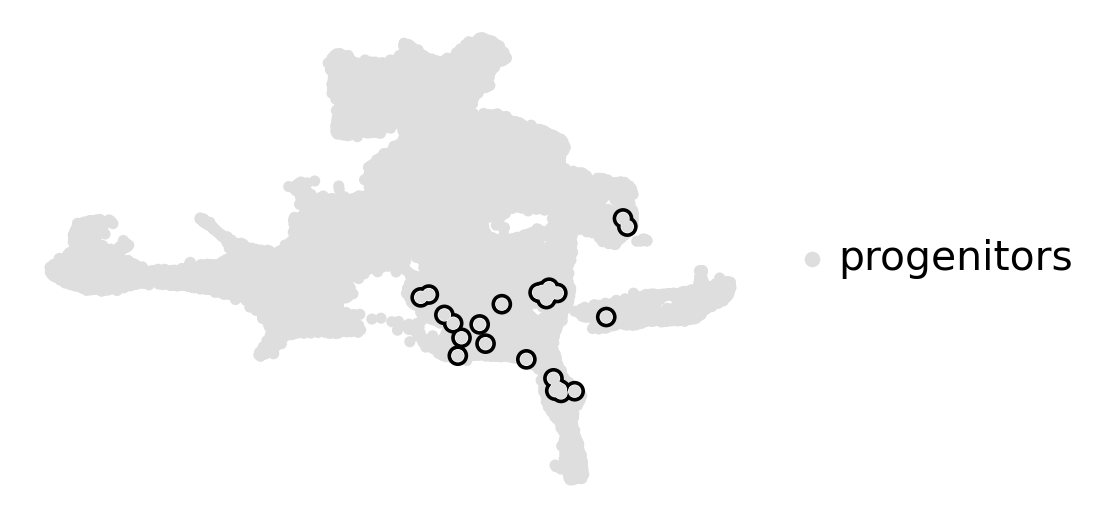

In [14]:
estimator.compute_macrostates(n_states=1, cluster_key="cluster_name")
if running_in_notebook():
    estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc="right", size=100)
    if SAVE_FIGURES:
        fpath = (
            FIG_DIR
            / "realtime_kernel"
            / "pharyngeal_endoderm"
            / f"umap_colored_by_macrostates_full_data-initial_state.{FIGURE_FORMAT}"
        )
        estimator.plot_macrostates(which="all", basis="umap", title="", legend_loc=False, size=100, save=fpath)